In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sepia.SepiaModel import SepiaModel
from sepia.SepiaData import SepiaData
from sepia.SepiaPredict import SepiaXvalEmulatorPrediction, SepiaEmulatorPrediction, SepiaFullPrediction

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Univariate-output with categorical input

### Create synthetic data

In this example, we use synthetic data generated as follows.

Simulation data: $y_{sim} = 2.5 \cos(0.2v)$ if $c == 1$, $y_{sim} = 2.5 \cos(0.2v - 0.5)$ if $c == 2$

Observed data: $y_{obs} = 2.5 \cos(0.2v) + \epsilon$ if $c == 1$, $y_{obs} = 2.5 \cos(0.2v - 0.5) + \epsilon$ if $c == 2$

where $\epsilon \sim N(0, \sigma^2_n)$.

In this case, $v$ is a univariate input variable and $c$ is a categorical input variable.

In the model, the simulation data output $y$ is assumed to vary smoothly with $v$, but the relationship depends on $c$.
The observed data output is assumed to conform to the same relationship (plus white noise),
but the true input value generating $y_{obs}$ would not be known in advance.
That is, in this example, we generate the $v$ and $c$ corresponding to $y_{obs}$, but in a real data situation,
this would be unknown.
We conventionally use $\theta$ to refer to the unknown input value that would generate the observed data.

First, we generate the synthetic data.

In [2]:
seed = 42   # random seed
m = 100     # number of simulated data observations
n = 1       # number of observed data observations
sig_n = 0.1 # observation noise SD

np.random.seed(seed)

# Sim data
v_sim = np.linspace(0, 10, m)[:, None]
y_sim = np.zeros((m, 1))
c_sim = np.zeros((m, 1))
for i in range(m):
    c_rand = np.random.choice([1, 2], size=1)
    c_sim[i, :] = c_rand
    if c_rand == 1:
        y_sim[i, :] = 2.5 * np.cos(0.2 * v_sim[i, :])
    else:
        y_sim[i, :] = 2.5 * np.cos(0.2 * v_sim[i, :] - 0.5)

# Obs data: c == 1
v_obs = np.array([[7.5]])
c_obs = np.array([[1]])
y_obs = 2.5 * np.cos(0.2 * v_obs) + sig_n * np.random.normal(size=(n, 1))

### Create SepiaData object

Next, we initialize the SepiaData object which does some basic checking about whether the input data
are of the correct shapes, and infers what kind of model you're going to use based on the input data.
In this case, we pass in $t_{sim}$, $y_{sim}$, and $y_{obs}$ to indicate that we have both simulated
and observed data.

In [3]:
# Combine t and c into one set of inputs
t_sim = np.concatenate([v_sim, c_sim], axis=1)
# t_cat_ind tells the model that the first column of t is not categorical, the second column has two categories
data = SepiaData(t_sim=t_sim, y_sim=y_sim, y_obs=y_obs, t_cat_ind=[0, 2])
print(data)

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 1, obs y dimension 1
n  =     1 (number of observed data)
m  =   100 (number of simulated data)
p  =     1 (number of inputs)
q  =     2 (number of additional simulation inputs to calibrate)
pu =     1 (univariate response dimension)Categorical t input variables:
t index 1 with 2 categories



This is what the data looks like: in the simulations, $y$ varies smoothly with $v$; the two colors denote $c = 1$ and $c = 2$.
The observed data $y$ is shown as a horizontal line.
Based on the $y$/$v$ relationship apparent in the simulations,
there are three regions where $v$ would produce values consistent with the observed $y$.

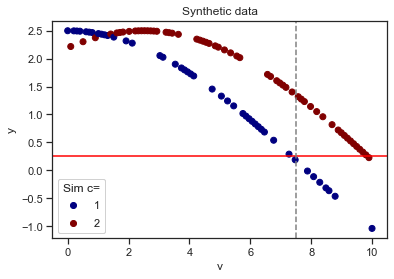

In [4]:
sc = plt.scatter(data.sim_data.t[:, 0], data.sim_data.y, c=data.sim_data.t[:, 1], cmap='jet')
plt.axhline(data.obs_data.y, color='red')
plt.axvline(v_obs, color='grey', linestyle='dashed')
plt.title('Synthetic data')
plt.xlabel('v')
plt.ylabel('y')
legend1 = plt.gca().legend(*sc.legend_elements(),
                    loc="lower left", title="Sim c=")
plt.gca().add_artist(legend1)
plt.show()

Standardization of data is important for default priors in the model to work well.

We transform $t$ to lie in [0, 1] and standardize the $y$ values.
Note that the $t$ transform does not apply to the categorical variable.

In [5]:
data.transform_xt()
data.standardize_y()

### Create SepiaModel using SepiaModel

Next, we set up the model object; a lot of precalculation of important model components is done here.

In [6]:
model = SepiaModel(data)

### Do MCMC

We will use all the default priors and settings to do MCMC.

We tune the step sizes, then draw 1000 MCMC samples.

In [7]:
model.tune_step_sizes(50, 20)
model.do_mcmc(1000)

Starting tune_step_sizes...
Default step sizes:
theta
[[0.2 0.2]]
betaU
[[0.1]
 [0.1]
 [0.1]]
lamUz
[[5.]]
lamWs
[[100.]]
lamWOs
[[100.]]
lamOs
[[500.]]


Step size tuning: 100%|██████████| 50/50 [00:05<00:00,  9.61it/s]


problem fitting glm on param theta index 1, reverting to default step size.
Done with tune_step_size.
Selected step sizes:
theta
[[0.06820127 0.2       ]]
betaU
[[0.14976359]
 [0.39789502]
 [0.68953896]]
lamUz
[[1.04953636]]
lamWs
[[11842.68563731]]
lamWOs
[[7903.57836263]]
lamOs
[[5434.57213711]]


MCMC sampling: 100%|██████████| 1000/1000 [00:05<00:00, 199.84it/s]


As a basic visualization, we will plot histograms of $\theta$ with the true $v_obs$ as a vertical line.

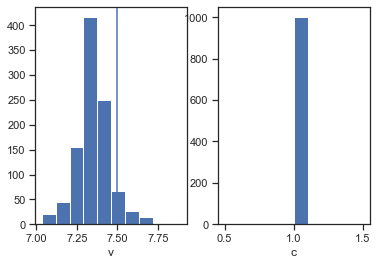

In [8]:
samples = model.get_samples()

plt.figure()
plt.subplot(121)
plt.hist(samples['theta_native'][:, 0])
plt.xlabel('v')
plt.axvline(v_obs)
plt.subplot(122)
plt.hist(samples['theta'][:, 1])
plt.xlabel('c')
plt.show()

### Model predictions
Finally, we will use the MCMC samples to do some predictions.
First, we get emulator predictions (which are predicting the $v$/$y$ relationship based on the simulation data).
The inputs `x_pred` and `t_pred` refer to simulation inputs where we want to predict; for now, we make these equal
to the `x` and `t` already in the model's simulation data object.
We also need to provide MCMC samples, so that the Gaussian process (GP) emulator parameters are taken from these samples.
The resulting `y` predictions are in the native space (standardization is un-done) though we can also predict in
standardized space, if desired.
We set `addResidVar = True` to get a sense of uncertainty in the GP.

We plot the predictions in blue along with the original simulation data in black:

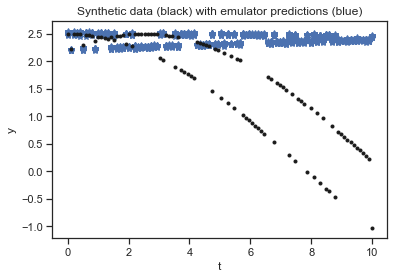

In [10]:
pred_samples = model.get_samples(numsamples=20)
pred = SepiaEmulatorPrediction(samples=pred_samples, model=model,
                               t_pred=model.data.sim_data.t_trans, addResidVar=True)
# Predictions are (size of sampleset, 100, 1)
y_pred = pred.get_y_native()

plt.plot(data.sim_data.t[:, 0], y_pred.squeeze().T, 'b*')
plt.plot(data.sim_data.t[:, 0], data.sim_data.y, 'k.')
plt.title('Synthetic data (black) with emulator predictions (blue)')
plt.xlabel('t')
plt.ylabel('y')
plt.show()


